In [85]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import solve_ivp
from scipy import interpolate
from scipy.optimize import fsolve
from scipy.interpolate import CubicSpline
from scipy.optimize import minimize

In [71]:
## Constants
G = 6.6743 * 1e-11 # Gravitational constant
M_Sun = 1.9885 * 1e30 # mass of the Sun in kg (from NASA)
R_earth = 6.371 * 1e6 # average radius of the earth in meters (from Wikipedia)
cm_to_m = 1e-2 # cm to m conversion
pi = np.pi
mass_threshold = 0.4 # Solar Mass unit


Implementation for Part(B)

In [3]:
def read_data(filename, plot_flag = False):
    ## Reads the data wd data and plots and returns the data with asked scalings and conversions

    ## Retrieve the data from the file
    data = pd.read_csv(filename)

    ## Extract the data
    wdid_array = np.asarray(data.wdid)
    logg_array = np.asarray(data.logg)
    mass_array = np.asarray(data.mass)
    
    ## Convert to radius using Newtonian gravity    
    scaled_r_array = (np.sqrt(G * (mass_array * M_Sun) / (cm_to_m * np.power(10,logg_array)))) / R_earth # scaled radii in units of average earth radius
    
    ## Plot the data
    if (plot_flag):
        plt.figure(figsize=(10,5))
        plt.scatter(scaled_r_array, mass_array)
        plt.xlabel("Radius (Average Earth Radius)")
        plt.ylabel("Mass (Solar Mass)")
        plt.title("Mass vs Radius of White Dwarf Data")
        plt.show()
    return mass_array, scaled_r_array


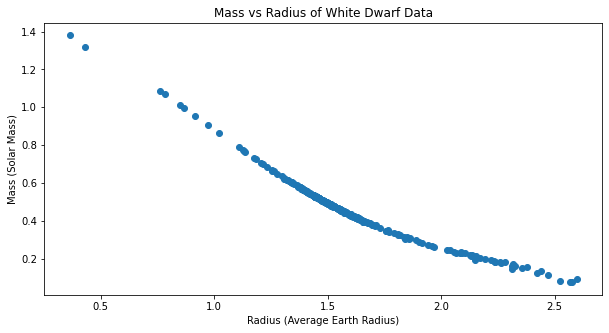

In [4]:
read = read_data("white_dwarf_data.csv",True)

Implementation for Part(C)

In [5]:
def fit_data():
    mass_data, r_data = read_data("white_dwarf_data.csv")
    mass_threshold = 0.4 # Solar Mass unit

    ## Filter the data using the mass threshold
    filtered_mass_data = mass_data[mass_data<mass_threshold] # Filtered Mass Data
    filtered_r_data = r_data[mass_data<mass_threshold] # Filtered Radius Data
    N = filtered_mass_data.shape[0] # Number of samples after filtering 

    ## I will do a linear fit to the logarithmic data due to the linear relation between lnM and lnR
    ln_filtered_r_data = np.log(filtered_r_data)
    ln_filtered_mass_data = np.log(filtered_mass_data)


    ## Do a linear fit
    fit_coefficients = np.polyfit(ln_filtered_r_data, ln_filtered_mass_data, 1)
    m = fit_coefficients[0] # first order coefficient 
    b = fit_coefficients[1] # zeroth order coefficient
    poly1d_fn = np.poly1d(fit_coefficients) 
    ## To visualize the data 
    plt.figure(figsize=(8,5))
    plt.plot(ln_filtered_r_data,ln_filtered_mass_data, 'yo', ln_filtered_r_data, poly1d_fn(ln_filtered_r_data), '--k')
    plt.xlabel("Radius (Average Earth Radius) - Logarithmic Scale")
    plt.ylabel("Mass (Solar Mass)")
    plt.title("Mass vs Radius of White Dwarf Data (Dwarf Mass < 0.4 Solar Mass)")  
    plt.text(0.5,-1.75,str(m) + "x + " + str(b))
    plt.legend(["Data", "Linear fit"])
    plt.show()

    ## Visual fit compared to the entire data

    ## Print the fit coefficients
    print("First order coefficient for the fit: " + str(m))
    print("Zeroth order coefficient for the fit: " + str(b))
    print("Sample Size: " + str(N))


In [82]:
def solve_ivp_lane_emden(n):
    ## Solves the lane-emden equation and returns the integration range, theta and derivative of theta
    ksi_bound = 30
    ## Define the right hand side of the lane-emden equation written in the solution set
    def lane_emden_rhs(ksi, current_state):
        next_state = np.zeros_like(current_state)
        # extract the parameters
        theta = current_state[0] 
        dtheta = current_state[1]
        next_state[0] = current_state[1] # theta evolution relation to its derivative

        ## Handle the case where ksi is in the denominator -- set rhs directly to 0 initially
        if(ksi != 0):
            next_state[1] = -((2/ksi) * dtheta + np.power(theta,n))
        
        return next_state
    
    initial_conditions = np.asarray([1,0]).astype('float')
    result = solve_ivp(lane_emden_rhs, t_span=(0,ksi_bound), y0 = initial_conditions, max_step = 1e-3) # max step for smoother output

    ## Extract the solution
    ksi_range = result.t
    theta_array = result.y[0,:]
    dtheta_array = result.y[1,:]

    return ksi_range, theta_array, dtheta_array


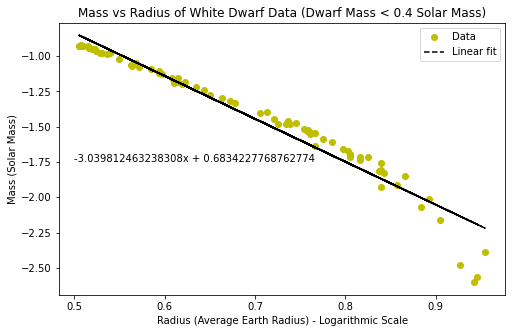

First order coefficient for the fit: -3.039812463238308
Zeroth order coefficient for the fit: 0.6834227768762774
Sample Size: 76


/var/folders/j2/_m2jcv351b1bl0wyjjwt_0jr0000gn/T/ipykernel_15295/1127672501.py:14: RuntimeWarning: invalid value encountered in power
  next_state[1] = -((2/ksi) * dtheta + np.power(theta,n))


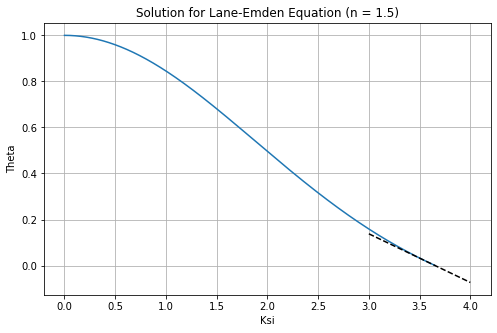

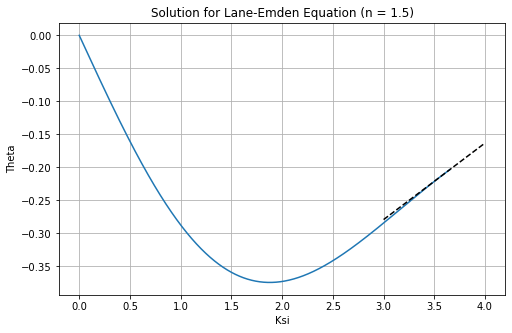

ksi_n = 3.653083969542544
dtheta(ksi_n) = -0.20330250655674104
K_star = 5.40582658418237


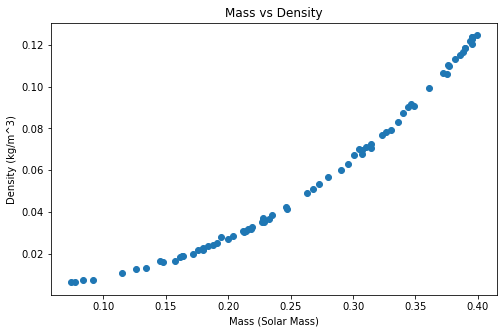

In [83]:
fit_data()
n_star = 1.5
ksi_range, theta_array, dtheta_array = solve_ivp_lane_emden(n_star)


## Do a linear fit to the linear-like end of the plot of theta to find the root
fit_ksi_range = ksi_range[ksi_range>3.5]
fit_theta_range = theta_array[ksi_range>3.5]
fit_coefficients = np.polyfit(fit_ksi_range, fit_theta_range, 1)
poly1d_fn = np.poly1d(fit_coefficients) 
root = np.roots(poly1d_fn)[0]
ksi_n = root

linear_fit_ksi_range = np.linspace(3,4)
plt.figure(figsize=(8,5))
plt.plot(ksi_range, theta_array)
plt.plot(linear_fit_ksi_range, poly1d_fn(linear_fit_ksi_range),'--k')
plt.grid()
plt.xlabel('Ksi')
plt.ylabel('Theta')
plt.title('Solution for Lane-Emden Equation (n = 1.5)')
plt.show()


## Do a linear fit to the linear-like end of the plot of dtheta to find the root
fit_ksi_range = ksi_range[ksi_range>3.5]
fit_dtheta_range = dtheta_array[ksi_range>3.5]
fit_coefficients = np.polyfit(fit_ksi_range, fit_dtheta_range, 1)
poly1d_fn = np.poly1d(fit_coefficients) 
dtheta_ksi_n = poly1d_fn(ksi_n)


plt.figure(figsize=(8,5))
plt.plot(ksi_range, dtheta_array)
plt.plot(linear_fit_ksi_range, poly1d_fn(linear_fit_ksi_range),'--k')
plt.grid()
plt.xlabel('Ksi')
plt.ylabel('Theta')
plt.title('Solution for Lane-Emden Equation (n = 1.5)')
plt.show()

## Print the estimated values
print("ksi_n = " + str((ksi_n)))
print("dtheta(ksi_n) = " + str(dtheta_ksi_n))

## Calculation of K_star
def K_star_relation(K_star):
    return np.log(-4*pi * np.power(4*pi*G/((n_star + 1)*K_star),(n_star/(1 - n_star)))  * np.power(ksi_n,((n_star + 1)/(n_star-1))) * dtheta_ksi_n) - 0.6834

root = np.roots(poly1d_fn)[0]
K_star = root

print("K_star = " + str(K_star))

mass_data, r_data = read_data("white_dwarf_data.csv")
low_mass_WD = mass_data[mass_data<mass_threshold]
low_r_WD = r_data[mass_data<mass_threshold]

## Calculation and plot of rho_c

rho_c_array = (low_mass_WD)/(4*pi*np.power(low_r_WD,3)) * (-ksi_n/dtheta_ksi_n)

#Plotting the Data
plt.figure(figsize=(8,5))
plt.scatter(low_mass_WD, rho_c_array)
plt.xlabel('Mass (Solar Mass)')
plt.ylabel('Density (kg/m^3)')
plt.title('Mass vs Density')
plt.show()






Implementation for Part(D)

In [80]:
def compute_radius_mass(rho, D_guess, q, K_star):
    ## This integrates over r the equation provided in the solution set to obtain mass and radius 

    C = (5 * K_star * np.float_power(D_guess, 5/q))/8 # Given as in the formula

    ## Solving the system of equations 
    def system_rhs(r, current_state):
        next_state = np.zeros_like(current_state)
        m = current_state[0]
        rho = current_state[1]
        x = np.power(rho/D_guess,1/q) # given relation
        ## Using mathematica dP/dx is calculated as
        dP_dx = (8*C*np.power(x,4)) / (np.sqrt(np.power(x,2) + 1))

        next_state[0] = 4*pi*np.power(r,2) * rho ## dm/dr

        if(r == 0):
            ## This relation is provided in the solution set relates evolution for d(rho)/dr
            next_state[1] = (1/dP_dx)*q*D_guess*np.power(rho/D_guess, -(1/q)+1) * (-G*m*rho/np.power(r, 2))
        return next_state
    
    initial_state = np.asarray([0, rho]).astype(float)

    result = solve_ivp(system_rhs, y0 = initial_state, t_span=(0,1e6))

    final_r = result.t[-1]
    final_M = result.y[0,-1]

    return final_r, final_M    

In [89]:
def get_rho_c_valid(D_guess, rho_c_initial, sample_size, min_R, max_R, q, K_star):
    ## Returns the rho sampling range that has valid corresponding radius values
    rho_c_range = rho_c_initial * np.logspace(0.15, 10, sample_size) ## get a set of rho_c values around our initial rho_c

    radius_array = []
    ## Compute the Radius values for the given rho_c
    for rho_c in rho_c_range:
        radius, mass = compute_radius_mass(rho_c, D_guess, q, K_star)
        radius_array.append(radius)

    filtered_rho = rho_c_range[radius<=max_R and radius >= min_R]

    return filtered_rho

In [90]:
def get_minErr_D(radius_arr, mass_arr, rho_c_initial, D_initial, sample_size, q, K_star):
    ## Gets the D minimizing the error 
    def error_function(D):
        ## Given D samples a valid rho range then finds the Mass and Radius values associated with those rho values
        ## Then makes a fit to the data using spline - using that spline fit evaluates the radius points given in the white_dwarf_data
        ## does a square error for fit evaluated data and observed data
        min_R = np.min(radius_arr)
        max_R = np.max(radius_arr)
        rho_range = get_rho_c_valid(D, rho_c_initial, sample_size, min_R, max_R, q, K_star)

        ## For given rho values compute the corresponding mass and radius values
        radius_array = []
        mass_array = []
        for rho_c in rho_range:
            radius, mass = compute_radius_mass(rho_c, D, q, K_star)
            radius_array.append(radius)
            mass_array.append(mass)

        radius_array = np.asarray(radius_array)
        mass_array = np.asarray(mass_array)

        ## To calculate the error we'll do a spline fit to the data, for many points spline does the trick
        fitted_curve = CubicSpline(radius_array,mass_array)

        ## Evaluate the points using fitted curve
        evaluated_values = fitted_curve(radius_arr)

        ## Calculate the error with respect to the fit
        size = len(mass_arr)
        # evaluated values - observed data
        error = np.sqrt(np.sum(np.power(evaluated_values - mass_arr,2)/len)) / M_Sun # scale with solar mass
    # use the built-in method
    result = minimize(error_function, D_initial)
        

In [92]:
## TO DO : Get D guess
sample_size = 5 # repetations of ivp for each D value
q = 3
## Get the initial rho_c value
rho_c_array = mass_data/(4*pi*np.power(r_data,3)) * (-ksi_n/dtheta_ksi_n)
rho_c_n_initial = rho_c_array[0] 

## as x = (rho/D)^1/3 relation given
# for initial guess of D start from low mass case so x = small as given in the hint
small_x = 0.001
D_initial = rho_c_n_initial / np.power(small_x,3)

D = get_minErr_D(r_data,mass_data,rho_c_n_initial, D_initial, sample_size, q, K_star)

# Calculate C using the relation 
C = (5 * K_star * np.float_power(D, 5/q)) / 8

## takes too long to execute even for sample_size 5
print(C)
print(D)



/var/folders/j2/_m2jcv351b1bl0wyjjwt_0jr0000gn/T/ipykernel_15295/3116088339.py:19: RuntimeWarning: invalid value encountered in double_scalars
  next_state[1] = (1/dP_dx)*q*D_guess*np.power(rho/D_guess, -(1/q)+1) * (-G*m*rho/np.power(r, 2))


KeyboardInterrupt: 